# Predictive maintenance with classification models

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from timeit import default_timer as timer   # for measuring computation time
from pympler import asizeof                 # for measuring ML object size

# import self defined functions
from add_remaining_useful_life import add_remaining_useful_life
from evaluate import evaluate
from determine_rul import determine_rul

In [64]:
dir_path = './input/'
train_file = 'PM_train.txt'
train_location = dir_path + train_file
test_file = 'PM_test.txt'
test_location = dir_path + test_file
truth_file = 'PM_truth.txt'
truth_location = dir_path + truth_file

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['s{}'.format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_location, sep='\s+', header=None, names=col_names)    # s+ -> regex for spaces/tabs as spaces
test = pd.read_csv(test_location, sep='\s+', header=None, names=col_names)
y_truth = pd.read_csv(truth_location, sep='\s+', header=None, names=['RUL'])

train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [65]:
# inspect cycles of train data
train[index_names].groupby('id').max().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle,100.0,206.31,46.342749,128.0,177.0,199.0,229.25,362.0


In [66]:
# Computation of RUL
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train[index_names+['RUL']].head()
train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [67]:
# adjust RUL value by truth values
for i in range(len(test)):
    currentID = test['id'][i]
    current_truth_value = y_truth['RUL'][currentID - 1]
    test['RUL'][i] = test['RUL'][i] + current_truth_value


,0
count,100.000000
mean,130.960000
std,53.593479
min,31.000000
25%,88.750000
50%,133.500000
75%,164.250000
max,303.000000


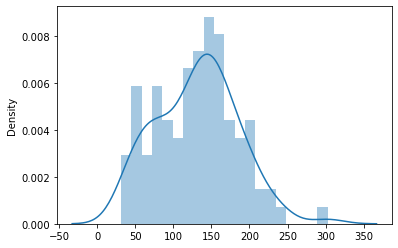

In [68]:
# get period duration of test dataset
list_periods = []
for i in range(0, len(test)):
    if i + 1 < len(test):
        if test['cycle'][i] > test['cycle'][i + 1]:
            list_periods.append(test['cycle'][i])
    else:
        list_periods.append(test['cycle'][i])
sns.distplot(list_periods, bins=20)
pd.DataFrame(list_periods).describe()

In [69]:
# add TTL (time to failure) variable
# an increase of period results for better accuracy, but cycles smaller than period will be ignored
# tradeoff between accuracy and ignored RULs with small cycle durations

period = 30

train['label_bc'] = train['RUL'].apply(lambda y: 1 if y <= period else 0)
test['label_bc'] = test['RUL'].apply(lambda y: 1 if y <= period else 0) 
train.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0,1


In [70]:
# define test and training features
drop_sensors = 's1 s5 s6 s10 s16 s18 s19'.split(' ')
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = 's2 s3 s4 s7 s8 s9 s11 s12 s13 s14 s15 s17 s20 s21'.split(' ')

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('label_bc')
X_test = test.drop(drop_labels, axis=1)
y_test = X_test.pop('label_bc')

X_train.drop('RUL', axis=1, inplace=True)
X_test.drop('RUL', axis=1, inplace=True)

id_test = np.reshape(np.array(test['id']),((X_test.shape[0],1)))
id_train = np.reshape(np.array(train['id']),((X_train.shape[0],1)))

The other method to predict the RUL is using classification models. In order to effectively use a classification method a proper feature has to be added. 
In this dataset, we classify if certain sensor values lead to a failure of a system. A failure is marked as 1, whereas a proper operation has 0 as its value. 
We also define a TTF (time to failure) time and a 'period' variable which defines the number of cycles left until RUL. 

## Random Forest as classification model

In [71]:
rf_clas = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=15, min_samples_leaf=50)

# fit model
start = timer()
rf_clas.fit(X_train, y_train)
end = timer()
time_rf = end - start
print('Time for training of Random Forest Model: ' + str(round(time_rf, 2)) + 's. ')   
memspace_rf = asizeof.asizeof(rf_clas)
print('Memory allocation of Random Forest object: ' + str(memspace_rf/1e6) + 'MB')

Time for training of Random Forest Model: 35.54s. 
Memory allocation of Random Forest object: 0.620792MB


In [72]:
# predictions
predictions = rf_clas.predict(X_test)
errors = abs(predictions - y_test)

# Print out the mean absolute error
print('Mean Absolute Error:', round(np.mean(errors), 2))    # cannot compare regression/classification errors 

Mean Absolute Error: 0.01


In [73]:
print('Accuracy of model on test data: ',accuracy_score(np.array(y_test), predictions))
print('Confusion Matrix: \n',confusion_matrix(np.array(y_test), predictions))

Accuracy of model on test data:  0.9867135003054368
Confusion Matrix: 
 [[12715    49]
 [  125   207]]


### Calculation of RUL for Random Forest

In [74]:
rul_list_rf = determine_rul(predictions, y_test, X_test, test, period)

In [75]:
# evaluate RSME
rsme_rf = evaluate(y_truth, rul_list_rf, label='rf')

rf set RMSE:61.38020853662849, R2:-1.1817107672750744


## KNN Model

In [76]:
# find best number of neighbours
accuracy_n = np.zeros(50)
for n in range(1, accuracy_n.shape[0]):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    accuracy_n[n] = knn.score(X_test, y_test)

0.9834300549786195


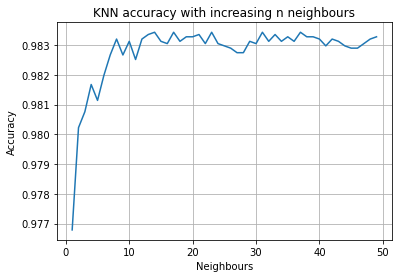

In [77]:
# plot accuracy depending on #neighbours
N = np.arange(0, accuracy_n.shape[0])
plt.plot(N[1:50], accuracy_n[1:50])
plt.xlabel('Neighbours')
plt.ylabel('Accuracy')
plt.title('KNN accuracy with increasing n neighbours')
print(accuracy_n.max())
plt.grid(True)

An ideal number of neighbours would be 23. With further increase of the number of neighbors the accuracy cannot be drastically improved. Thus, n = 23 is chosen for the KNN model design. 

In [78]:
#KNN model with N = 23
knn = KNeighborsClassifier(n_neighbors = 23)
start_knn = timer()
knn.fit(X_train, y_train)
end_knn = timer()
time_knn = end_knn - start_knn
print('time for training of KNN Model: ' + str(round(time_knn,2))+ ' s')
memspace_knn = asizeof.asizeof(knn)/1e6
print('Memory allocation of KNN objekt: ' + str(round(memspace_knn,2))+ ' MB')

time for training of KNN Model: 0.17 s
Memory allocation of KNN objekt: 2.4 MB


In [79]:
Y_pred_KNN = knn.predict(X_test)
confusion_matrix_KNN = confusion_matrix(y_test, Y_pred_KNN)
accuracy_KNN = knn.score(X_test, y_test)
print('Confusion Matrix: \n',confusion_matrix_KNN)
print('accuracy:', accuracy_KNN)

Confusion Matrix: 
 [[12709    55]
 [  162   170]]
accuracy: 0.9834300549786195


### Calculation of RUL for KNN model

In [80]:
rul_list_knn = determine_rul(Y_pred_KNN, y_test, X_test, test, period)

In [81]:
# evaluate RSME
rsme_knn = evaluate(y_truth, rul_list_knn, label='knn')

knn set RMSE:61.447457229734084, R2:-1.186493988891808


## Support vector machine (SVM) model

In [82]:
# find the best factor "C"
accuracy_C = np.zeros(50)
for i in range (1, accuracy_C.shape[0]):
    logreg = LogisticRegression(C=i).fit(X_train, y_train) # C: Unregelmädigkeitsfaktor
    accuracy_C [i] = logreg.score(X_test, y_test)

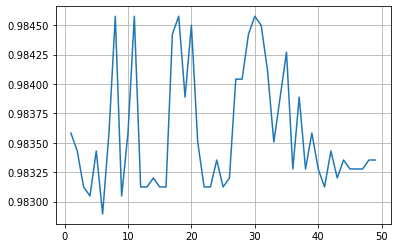

In [83]:
# plot C
C = np.arange(0, accuracy_C.shape[0])
plt.plot(C[1:50], accuracy_C[1:50])
plt.grid(True)

In [84]:
# for C = 8:
start_SVM = timer()
logreg = LogisticRegression(C=8).fit(X_train, y_train)
end_SVM = timer()
time_svm = end_SVM - start_SVM
print('time for training of SVM Model: ' + str(round(time_svm,2))+ ' s')
memspace_svm = asizeof.asizeof(logreg)
print('Memory allocation of SMV objekt: ' + str(round(memspace_svm,2))+ ' MB')

time for training of SVM Model: 0.55 s
Memory allocation of SMV objekt: 2712 MB


In [85]:
Y_pred_SVM = logreg.predict(X_test)
confusion_matrix_SVM = confusion_matrix(y_test, Y_pred_SVM)
accuracy_SVM = logreg.score(X_test, y_test)
print('Confusion Matrix: \n',confusion_matrix_SVM)
print('accuracy:', accuracy_SVM)

Confusion Matrix: 
 [[12710    54]
 [  148   184]]
accuracy: 0.9845754428833231


In [86]:
rul_list_svm = determine_rul(Y_pred_SVM, y_test, X_test, test, period)

In [87]:
# evaluate using Regression evaluation
rsme_svm = evaluate(y_truth, rul_list_svm, label='svn')
train.head()

svn set RMSE:61.41661013113635, R2:-1.1842992661403042


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


## LSTM (Long Short Term Memory) model

In [90]:
train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [91]:
# scaling
sc = MinMaxScaler()
print(remaining_sensors)
train[remaining_sensors]=sc.fit_transform(train[remaining_sensors])
test[remaining_sensors]=sc.transform(test[remaining_sensors])

#to predict classification
target_col_name='label_bc'

# generate X_train
X_train = np.array(train[remaining_sensors])

# generate y_train classification
Y_train= train[target_col_name]

# generate X_test
X_test = np.array(test[remaining_sensors])

# generate y_test classification
Y_test = test[target_col_name]

['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [92]:
#generate training dataset for LMST
sequence = 50
X_train_LSTM = np.zeros((X_train.shape[0]-sequence,sequence, X_train.shape[1])) #start matrix
id_train = np.reshape(np.array(train['id']),((X_train.shape[0],1)))
X_train_help = np.hstack((id_train, X_train)) #add id in trainings set

for i in range (sequence, X_train.shape[0]-1):          # row (cycle)
    for k in range (0, sequence -1):                    # column (old sensor values)
           for j in range (0, X_train_help.shape[1]-1): # column sekound dimension (sensor values)
                if X_train_help[i-k, 0] - X_train_help[i, 0] >= 0:
                    X_train_LSTM[i-sequence, k, j] = X_train_help[i-k, j+1] #overwrite values

#generate Y train for LMST with same shape
Y_train_LSTM = np.zeros((Y_train.shape[0] - sequence))

for i in range (sequence, Y_train.shape[0]-1): 
    Y_train_LSTM [i-sequence] = Y_train [i]

#generate testing dataset for LMST
X_test_LSTM = np.zeros((X_test.shape[0], sequence, X_test.shape[1]))
id_test = np.reshape(np.array(test['id']),((X_test.shape[0],1)))
X_test_help = np.hstack((id_test, X_test)) #add id in test set

for i in range (0, X_test.shape[0]-1):                 # row (cycle)
    for k in range (0, sequence -1):                   # column (old sensor values)
           for j in range (0, X_test_help.shape[1]-1):        # column sekound dimension (sensor values)
                if i - k >= 0:
                    if X_test_help[i-k, 0] - X_test_help[i, 0] >= 0:
                        X_test_LSTM[i, k, j] = X_test_help[i-k, j+1] #overwrite values
                        
np.shape(X_test_LSTM)

(13096, 50, 14)

In [93]:
nb_features =X_train_LSTM.shape[2]
timestamp=sequence

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           46000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 76,251
Trainable params: 76,251
Non-trainable params: 0
_________________________________________________________________


In [94]:
# fit the network
start_LSTM = timer()
model.fit(X_train_LSTM, Y_train_LSTM, epochs=20, batch_size=200, validation_split=0.05, verbose=1)
          #callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
end_LSTM = timer()
time_lstm = end_LSTM - start_LSTM
print('time for training of LSTM Model: ' + str(round(time_lstm,2))+ ' s')
memspace_lstm = asizeof.asizeof(model)
print('Memory allocation of LSTM objekt: ' + str(round(memspace_lstm,2))+ ' MB')

Epoch 1/20
98/98 [==============================] - 34s 351ms/step - loss: 0.3200 - accuracy: 0.8865 - val_loss: 0.2522 - val_accuracy: 0.8505
Epoch 2/20
98/98 [==============================] - 48s 488ms/step - loss: 0.3526 - accuracy: 0.8569 - val_loss: 0.4242 - val_accuracy: 0.8505
Epoch 3/20
98/98 [==============================] - 48s 491ms/step - loss: 0.4259 - accuracy: 0.8494 - val_loss: 0.3818 - val_accuracy: 0.8505
Epoch 4/20
98/98 [==============================] - 47s 479ms/step - loss: 0.2880 - accuracy: 0.8764 - val_loss: 0.1280 - val_accuracy: 0.9505
Epoch 5/20
98/98 [==============================] - 48s 487ms/step - loss: 0.1292 - accuracy: 0.9499 - val_loss: 0.1169 - val_accuracy: 0.9485
Epoch 6/20
98/98 [==============================] - 41s 417ms/step - loss: 0.1109 - accuracy: 0.9544 - val_loss: 0.1224 - val_accuracy: 0.9466
Epoch 7/20
98/98 [==============================] - 16s 160ms/step - loss: 0.1029 - accuracy: 0.9561 - val_loss: 0.0899 - val_accuracy: 0.9592

In [95]:
# training metrics
scores = model.evaluate(X_train_LSTM, Y_train_LSTM, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

103/103 [==============================] - 5s 46ms/step - loss: 0.0421 - accuracy: 0.9826
Accurracy: 0.9826053380966187


In [96]:
Y_pred_LSTM=model.predict_classes(X_test_LSTM)

confusion_matrix_LSTM = confusion_matrix(y_test, Y_pred_LSTM)
accuracy_LSTM = (confusion_matrix_LSTM[0,0]+confusion_matrix_LSTM[1,1])/(confusion_matrix_LSTM[0,0]+confusion_matrix_LSTM[0,1]+confusion_matrix_LSTM[1,0]+confusion_matrix_LSTM[1,1])
print('Accuracy of model on test data: ',accuracy_LSTM)
print('Confusion Matrix: \n',confusion_matrix_LSTM)

Accuracy of model on test data:  0.9919822846670739
Confusion Matrix: 
 [[12735    29]
 [   76   256]]


In [97]:
rul_list_lstm = determine_rul(Y_pred_LSTM, y_test, X_test, test, period)
rsme_lstm = evaluate(y_truth, rul_list_lstm, label='lstm')

lstm set RMSE:61.29453482978723, R2:-1.1756246099879233


In [98]:
# Comparison: computation time vs. accuracy/RMSE vs. memory space

In [99]:
comp_times = [time_knn, time_rf, time_svm, time_lstm]                   # in s
accuracies = [rsme_knn, rsme_rf, rsme_svm, rsme_lstm]                   # in RMSE 
memspaces = [memspace_knn, memspace_rf, memspace_svm, memspace_lstm]    # in MB
models = ['KNN', 'RF', 'SVR', 'LSTM']
mem_sizes = np.array(memspaces)
mem_sizes = mem_sizes/1e6

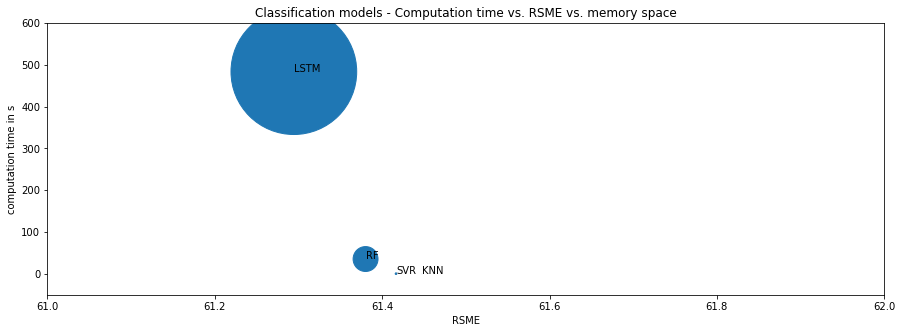

In [100]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x=accuracies, y=comp_times, s=mem_sizes*1000)
plt.xlabel('RSME')
plt.ylabel('computation time in s')
plt.title('Classification models - Computation time vs. RSME vs. memory space')
plt.xlim(61, 62)
plt.ylim(-50, 600)
# plt.axhline(lw=1, c='b')

for i, txt in enumerate(models):
    ax.annotate(txt, (accuracies[i], comp_times[i]))
